In [14]:
import time

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from src.evaluate_regression import get_rankings, average_spearman


sns.set_theme(style="whitegrid")
sns.set_palette(palette="Set2")

np.random.seed(7)

In [3]:
# Constants for supervisors functions
FACTORS = ["dataset", "model", "tuning", "scoring"]
NEW_INDEX = "encoder"
TARGET = "cv_score"

# Load Data

In [5]:
print("Loading processed train and validation set ...")

X_train = pd.read_csv("../../data/preprocessed/X_train.csv")
y_train = pd.read_csv("../../data/preprocessed/y_train.csv")
X_val = pd.read_csv("../../data/preprocessed/X_val.csv")
X_val_original = pd.read_csv("../../data/preprocessed/X_val_original.csv")
y_val = pd.read_csv("../../data/preprocessed/y_val.csv")

print("Shape of X_train", X_train.shape)
print("Shape of y_train", y_train.shape)
print("Shape of X_val", X_val.shape)
print("Shape of X_val_original", X_val_original.shape)
print("Shape of y_val", y_val.shape)

Loading processed train and validation set ...
Shape of X_train (26989, 112)
Shape of y_train (26989, 1)
Shape of X_val (9065, 112)
Shape of X_val_original (9065, 5)
Shape of y_val (9065, 1)


In [6]:
X_train.head(5)

,dataset,model_DTC,model_KNC,model_LGBMC,model_LR,model_SVC,tuning_full,tuning_model,tuning_no,scoring_ACC,...,non_categorical_features_count,ratio_of_categorical_features_to_all,sum_of_all_categories,categorical_target_variables_count,non_categorical_target_variables_count,categorical_target_values_sum,total_feature_count,min_number_of_categories_per_cat_feature,max_number_of_categories_per_cat_feature,avg_number_of_categories_per_cat_feature
0,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
1,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
2,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
3,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
4,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681


# Testing different baseline models

In [8]:
def get_average_spearman(X_val_original, y_val, y_pred) -> float:

    df_pred = pd.concat([X_val_original, y_val, y_pred], axis=1)
    rankings_test = get_rankings(df_pred, factors=FACTORS, new_index=NEW_INDEX, target="cv_score")
    rankings_pred = get_rankings(df_pred, factors=FACTORS, new_index=NEW_INDEX, target="cv_score_pred")
    avg_spearman = average_spearman(rankings_test, rankings_pred)

    return avg_spearman

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score

#######################################################
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
dt = DecisionTreeRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
lassocv = LassoCV(n_jobs=-1, random_state=42, max_iter=20000)
mlp = MLPRegressor(random_state=42)
svr = SVR()

models = [rf, dt, xgb, lassocv, mlp, svr]
#######################################################

def fit_and_predict(models: list, X_train, y_train, X_val, y_val, X_val_original):

    model_string_list = []
    spearman_list = []
    fitted_models = []
    fit_time = []
    pred_scoring_time = []  # Contains time taken for prediction AND average spearman scoring only!
    mse = []
    r2 = []

    for model in models:
        model_string = str(model).split("(")[0]
        model_string_list.append(model_string)
        print(f"Fitting {model_string} ...")
        start = time.time()
        # Fit model
        model.fit(X_train, y_train.values.flatten())
        fit_time.append(np.round((time.time() - start), 4))

        # Predicting
        start = time.time()
        print("Making prediction on validation set ...")
        y_pred = pd.DataFrame(model.predict(X_val), columns=["cv_score_pred"])

        # Scoring
        print("Get average spearman score ...")
        spearman = get_average_spearman(X_val_original, y_val, y_pred)

        pred_scoring_time.append(np.round((time.time() - start), 4))

        print("Append results ...\n")
        spearman_list.append(spearman)
        fitted_models.append(model)
        mse.append(mean_squared_error(y_true=y_val, y_pred=y_pred))
        r2.append(r2_score(y_true=y_val, y_pred=y_pred))

    # Build result dataframe
    res = pd.DataFrame({
        "fit_time": fit_time,
        "pred_scoring_time": pred_scoring_time,
        "average_spearman": spearman_list,
        "mse": mse,
        "r2": r2
    }, index=model_string_list)

    return res, fitted_models


res, fitted_models = fit_and_predict(models, X_train, y_train, X_val, y_val, X_val_original)

Fitting RandomForestRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Append results ...

Fitting DecisionTreeRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Append results ...

Fitting XGBRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Append results ...

Fitting LassoCV ...
Making prediction on validation set ...
Get average spearman score ...
Append results ...

Fitting MLPRegressor ...
Making prediction on validation set ...
Get average spearman score ...
Append results ...

Fitting SVR ...
Making prediction on validation set ...
Get average spearman score ...
Append results ...



In [16]:
res

,fit_time,pred_scoring_time,average_spearman,mse,r2
RandomForestRegressor,29.6479,1.7707,0.542632,0.004722,0.908113
DecisionTreeRegressor,0.9190,1.6233,0.506089,0.007293,0.858075
XGBRegressor,10.6220,2.7338,0.411495,0.003308,0.935633
LassoCV,20.1670,2.2111,0.085040,0.023994,0.533084
MLPRegressor,5.7963,1.5322,0.201974,0.010405,0.797528
SVR,18.1892,10.6707,0.222268,0.013685,0.733685


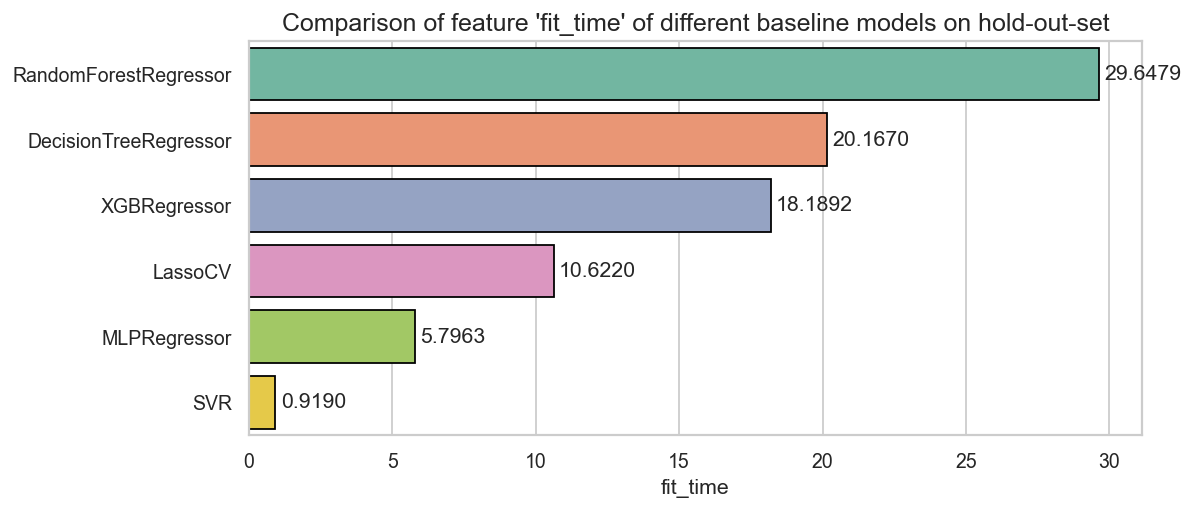

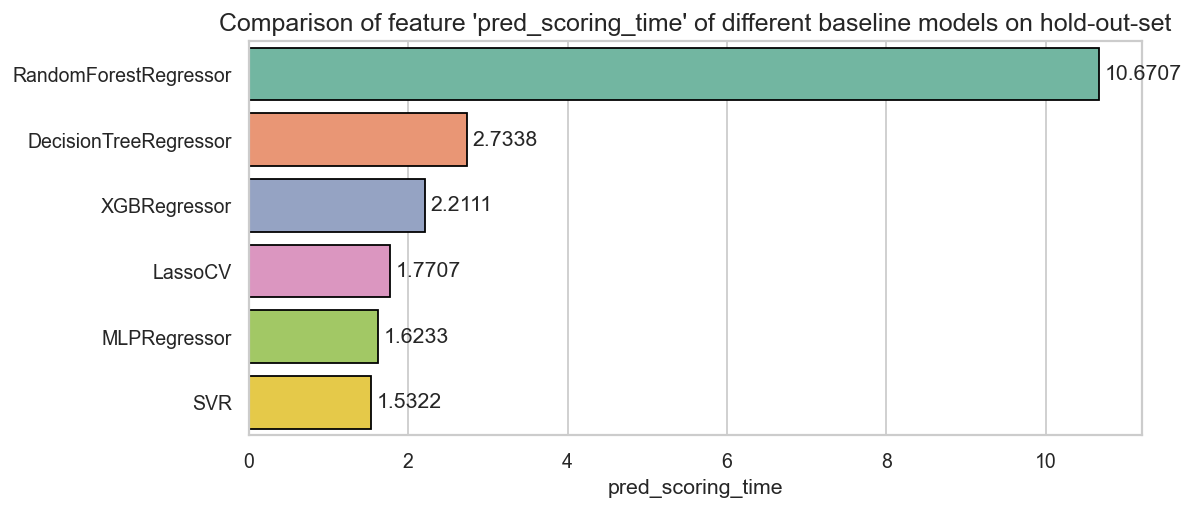

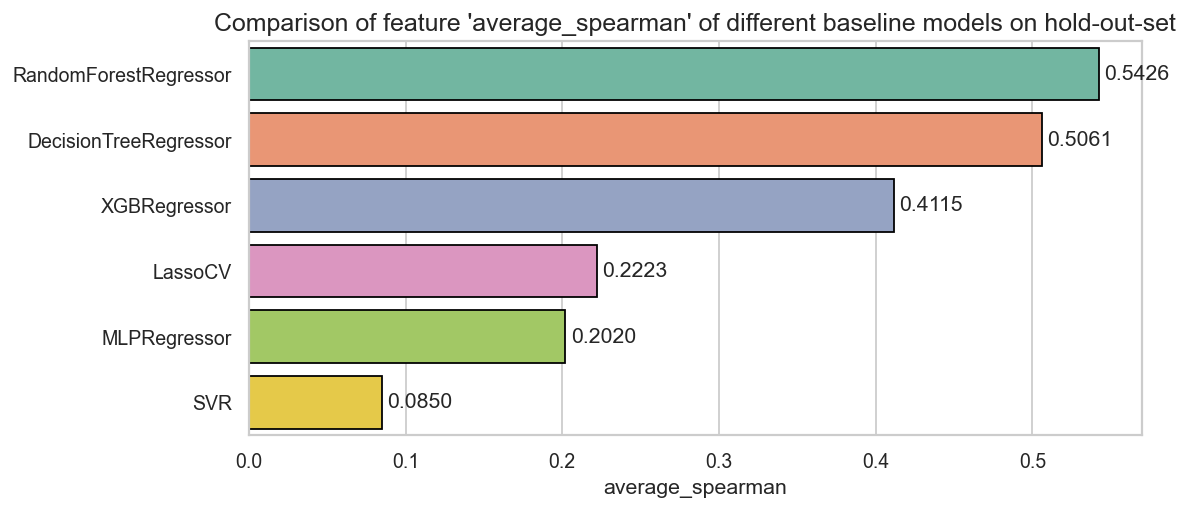

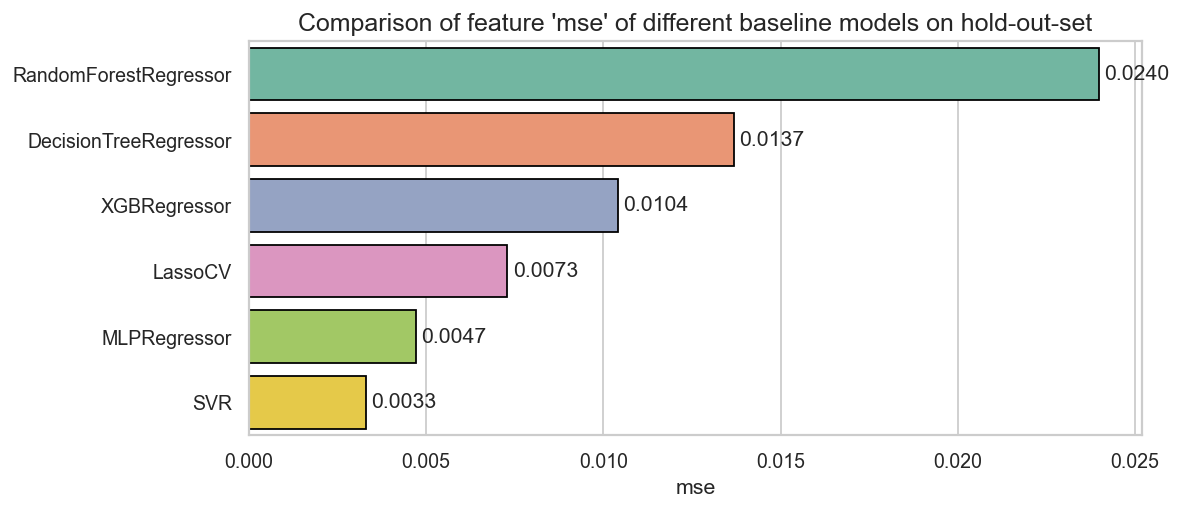

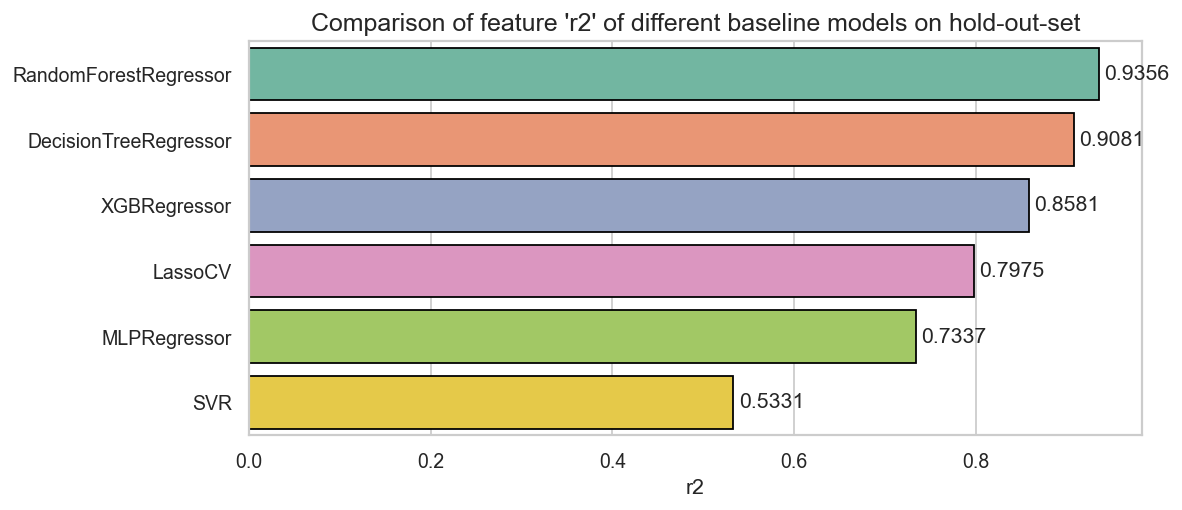

In [42]:
for col in res.columns:
    fig, ax = plt.subplots(1, 1, figsize=(9,4), dpi=128)#plt.figure(figsize=(9, 3), dpi=128)
    plt.title(f"Comparison of feature '{col}' of different baseline models on hold-out-set", size=14)
    g = sns.barplot(data=res.sort_values([col], ascending=False), y=res.index, x=col, edgecolor="black")
    g.bar_label(ax.containers[0], fmt="%.4f", padding=3)
    plt.show()